In [62]:
import matplotlib.pyplot as plt
import re
from datetime import datetime

stat_dump_interval_s = 2

def plot_client_results(axs, xlim):
    # Define the file paths
    # input_file_path = 'agg_thread.txt'
    input_file_path = 'status_thread.txt'
    # input_file_path = 'status_thread2.txt'

    # Initialize a dictionary to hold the data
    client_data = {}

    # Compile the regular expressions for matching lines
    client_regex = re.compile(r'client(\d+) stats:')
    
    # data_regex = re.compile(r'.*(\d+) operations; \[(READ|UPDATE): Count=(\d+) Max=\d+\.\d+ Min=\d+\.\d+ Avg=(\d+\.\d+) 90=\d+\.\d+ 99=(\d+\.\d+) 99.9=(\d+\.\d+) 99.99=\d+\.\d+\]')
    data_regex = re.compile(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).*operations; \[(READ|UPDATE|INSERT): Count=(\d+) Max=\d+\.\d+ Min=\d+\.\d+ Avg=(\d+\.\d+) 90=\d+\.\d+ 99=(\d+\.\d+) 99.9=(\d+\.\d+) 99.99=\d+\.\d+\]')
    def timestamp_to_seconds(timestamp_str):
        timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()
    
    start_time = None

    client_prev_times = {}
    
    # Open and read the input file
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        for i, line in enumerate(lines):
            client_match = client_regex.match(line)
            if client_match:
                client_id = client_match.group(1)
                # Check if the next line contains the data
                if i + 1 < len(lines):
                    data_match = data_regex.match(lines[i + 1])
                    if data_match:
                        # Extract the relevant data
                        timestamp_str, _, count, avg, p99, p999 = data_match.group(1, 2, 3, 4, 5, 6)
                        timestamp_s = timestamp_to_seconds(timestamp_str)
                        if start_time is None:
                            start_time = timestamp_s

                        if client_id in client_prev_times and timestamp_s < client_prev_times[client_id]:
                            client_id = str(int(client_id) + 2)
                        client_prev_times[client_id] = timestamp_s

                        # Check if the client ID already exists in the dictionary
                        if client_id not in client_data:
                            client_data[client_id] = {'Tput': [], 'Avg': [], '99': [], '999': [], 'ts': []}

                        # Append the data to the lists in the dictionary
                        client_data[client_id]['Tput'].append(int(count)*16*1024/(1024*1024)/stat_dump_interval_s)
                        client_data[client_id]['Avg'].append(float(avg)/1000)
                        client_data[client_id]['99'].append(float(p99)/1000)
                        client_data[client_id]['999'].append(float(p999)/1000)
                        client_data[client_id]['ts'].append(timestamp_s)
    


    def plot_metric(metric, title, ylabel, fig_loc):
        plt.figure(figsize=(8, 5))
        for client_id, stats in client_data.items():
            # time_points = [stat_dump_interval_s * i for i in range(len(stats[metric]))]
            # time_points = client_data[client_id]['ts']
            time_points = [ts - start_time for ts in client_data[client_id]['ts']]
            if metric == 'Count':
                data_points = [x for x in stats[metric]]
            else:
                data_points = [x for x in stats[metric]]
            axs[fig_loc[0]].plot(time_points, data_points, marker='o', label=f'Client {client_id}')
        
        if metric == 'Tput':
            client_tput_avgs = []
            client_tput_sums = []
            client_tput_len = min([len(client_data[client_id]['Tput']) for client_id in client_data])
            for i in range(client_tput_len):
                client_tput_sum = sum([client_data[client_id]['Tput'][i] for client_id in client_data])
                client_tput_sums.append(client_tput_sum)
                client_tpu_avg = client_tput_sum / len(client_data)
                client_tput_avgs.append(client_tpu_avg)
            # time_points = [stat_dump_interval_s * i for i in range(client_tput_len)]
            time_points = [ts - start_time for ts in client_data[client_id]['ts']]
            if len(time_points) > len(client_tput_avgs):
                time_points = time_points[:(len(client_tput_avgs)-len(time_points))]
            # axs[fig_loc[0]].plot(time_points, client_tput_avgs, marker='o', label='Average', color='black')
            # axs[fig_loc[0]].plot(time_points, client_tput_sums, marker='o', label='Sum')

        axs[fig_loc[0]].set_title(title)
        axs[fig_loc[0]].set_xlabel('Time (s)')
        axs[fig_loc[0]].set_xlim(xlim)
        axs[fig_loc[0]].set_ylabel(ylabel)
        axs[fig_loc[0]].legend()
        axs[fig_loc[0]].grid(True)
        # axs[fig_loc[0], fig_loc[1]].grid(True)

    # Plotting each metric
    plot_metric('Tput', 'Client Throughput', 'MB/s', (0, 0))
    plot_metric('Avg', 'Latency: Avg', '(ms)', (1, 0))
    plot_metric('99', 'Latency: 99p', '99th Percentile (ms)', (2, 0))

    return start_time


In [63]:
import matplotlib.pyplot as plt
import re
import json
from datetime import datetime

def level2color(level):
    if level == 1:
        return "#fc9598"
    elif level == 2:
        return "#ff696e"
    elif level == 3:
        return "#f02225"
    elif level == 4:
        return "#cf1d20"
    elif level == 5:
        return "#ab1619"
    elif level == 6:
        return "#851114"
    else:
    # elif level == 7:
        return "#610c0e"

def plot_rocksdb_events(axs, experiment_start_time, xlim, fig_loc):
    # log_file_path = '/mnt/multi-cf2/ycsb-rocksdb-data-2/LOG'
    log_file_path = '/mnt/multi-cf/ycsb-rocksdb-data/LOG'
    # log_file_path = '/mnt/tgriggs-disk/ycsb-rocksdb-data/LOG'
    flush_regex = re.compile(
        r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}\.\d{6}) \d+ \[/flush_job\.cc:\d+\] \[default\] \[JOB \d+\] Flush: (\d+) microseconds, \d+ cpu microseconds, (\d+) bytes'
    )
    l0_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[default\] Stalling writes because we have \d+ level-0 files rate (\d+)')
    memtable_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[default\] Stalling writes because we have \d+ immutable memtables.*rate (\d+)')
    pending_compaction_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[default\] Stalling writes because of estimated pending compaction bytes \d+ rate (\d+)')

    compaction_regex = re.compile(r'.*EVENT_LOG_v1 (.*)$')
    def timestamp_to_seconds(timestamp_str):
        timestamp = datetime.strptime(timestamp_str, '%Y/%m/%d-%H:%M:%S.%f')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()

    def timestamp_to_micros(timestamp_str):
        timestamp_format = '%Y/%m/%d-%H:%M:%S.%f'
        dt = datetime.strptime(timestamp_str, timestamp_format)
        epoch = datetime(1970, 1, 1)
        micros_since_epoch = int((dt - epoch).total_seconds() * 1000000)
        return micros_since_epoch

    # Initialize lists for all events
    l0_stalls, memtable_stalls, pending_compaction_stalls, flush_data, compaction_data = [], [], [], [], []

    # Process the log file for stall, flush, and compaction events
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # L0 and Memtable Stalls
            l0_match = l0_stall_pattern.search(line)
            if l0_match:
                timestamp_str, rate = l0_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                l0_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            memtable_match = memtable_stall_pattern.search(line)
            if memtable_match:
                timestamp_str, rate = memtable_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                memtable_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            pending_compact_match = pending_compaction_stall_pattern.search(line)
            if pending_compact_match:
                timestamp_str, rate = pending_compact_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                pending_compaction_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            # Flush Events
            flush_match = flush_regex.match(line)
            if flush_match:
                timestamp_str, flush_microseconds, flush_bytes = flush_match.groups()
                start_time_seconds = timestamp_to_seconds(timestamp_str) - int(flush_microseconds) / 1e6
                rate_MB_s = (int(flush_bytes) / int(flush_microseconds)) * 1e6 / (1024**2)
                flush_data.append((start_time_seconds, rate_MB_s, int(flush_microseconds)/1e6))
            
            # Compaction Events
            compaction_match = compaction_regex.match(line)
            if compaction_match:
                json_str = compaction_match.group(1)
                try:
                    event_data = json.loads(json_str)
                    if event_data['event'] != 'compaction_finished':
                        continue
                    end_time_seconds = event_data['time_micros'] / 1e6
                    start_time_seconds = end_time_seconds - event_data['compaction_time_micros'] / 1e6
                    # start_time_seconds = event_data['time_micros'] / 1e6
                    # end_time_seconds = start_time_seconds + event_data['compaction_time_micros'] / 1e6
                    read_rate = event_data['read_rate']
                    write_rate = event_data['write_rate']
                    output_level = event_data['output_level']
                    compaction_data.append((start_time_seconds, end_time_seconds, read_rate, write_rate, output_level))
                except:
                    print("Compaction json error")

    # Determine the overall start time
    all_start_times = [d[0] for d in flush_data + compaction_data + l0_stalls + memtable_stalls]
    # experiment_start_time = min(all_start_times)
    internal_start_time = min(all_start_times)
    print(internal_start_time)
    print(experiment_start_time)

    # Convert L0 and Memtable timestamps to seconds since experiment start
    l0_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in l0_stalls]
    l0_rates = [int(rate) for _, rate in l0_stalls]

    memtable_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in memtable_stalls]
    memtable_rates = [int(rate) for _, rate in memtable_stalls]

    pending_compaction_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in pending_compaction_stalls]
    pending_compaction_rates = [int(rate) for _, rate in pending_compaction_stalls]

    # Plotting
    # plt.figure(figsize=(8, 5))

    # Plot L0 and Memtable Stalls
    axs[fig_loc[0]].scatter(l0_timestamps, l0_rates, label='L0 Stalls', color='blue', s=10)
    axs[fig_loc[0]].scatter(memtable_timestamps, memtable_rates, label='Memtable Stalls', color='purple', s=10)
    axs[fig_loc[0]].scatter(pending_compaction_timestamps, pending_compaction_rates, label='Pend Compact Stalls', color='orange', s=10)

    # Plot Flush Events
    for start_time, rate, duration in flush_data:
        axs[fig_loc[0]].hlines(rate, start_time - experiment_start_time, (start_time + duration) - experiment_start_time, colors='green', linewidth=2, label='Flush' if flush_data.index((start_time, rate, duration)) == 0 else "")

    # Plot Compaction Events
    for start_time, end_time, read_rate, write_rate, output_level in compaction_data:
        color = level2color(output_level)
        axs[fig_loc[0]].hlines(write_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors=color, linewidth=2, label='Compaction' if compaction_data.index((start_time, end_time, read_rate, write_rate, output_level)) == 0 else "")
        # axs[fig_loc[0]].hlines(read_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors=color, linewidth=2, label='Compaction Read' if compaction_data.index((start_time, end_time, read_rate, write_rate, output_level)) == 0 else "")
        # axs[fig_loc[0]].hlines(write_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors=color, linewidth=2, label='Compaction Write' if compaction_data.index((start_time, end_time, read_rate, write_rate, output_level)) == 0 else "")
    
    axs[fig_loc[0]].set_title('Database Operations Over Time')
    axs[fig_loc[0]].set_xlabel('Time (seconds since start of experiment)')
    axs[fig_loc[0]].set_ylabel('MB/s')
    axs[fig_loc[0]].set_xlim(xlim)
    axs[fig_loc[0]].set_ylim(0, 400)
    axs[fig_loc[0]].legend()
    axs[fig_loc[0]].grid(True)
    # plt.show()

In [64]:
# Overall throughputs (client + system)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import time

max_read_tput = 700
max_read_iops = 180000
max_write_tput = 400
max_write_iops = 100000

def timestamp_to_seconds(timestamp_str):
  timestamp = datetime.strptime(timestamp_str.rstrip(), '%Y-%m-%d %H:%M:%S.%f')
  epoch = datetime(1970, 1, 1)
  return (timestamp - epoch).total_seconds()

def plot_overall_tputs(axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")

  # print(f"Timestamp: {timestamp_to_seconds(df_from_csv['Timestamp'][0])}")

  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  # Plotting
  # axs[fig_loc[0]].figure(figsize=(10, 6))
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["rMB/s"], label='Read MB/s', marker='o', color='tab:green')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["wMB/s"], label='Write MB/s', marker='o', color='tab:red')

  axs[fig_loc[0]].set_title('SSD Throughput Over Time')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('MB/s')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,16)
  axs[fig_loc[0]].legend(loc='upper left')
  axs[fig_loc[0]].grid(True)

  # Creating a second y-axis
  ax2 = axs[fig_loc[0]].twinx()
  # Plotting on the secondary y-axis
  ax2.plot(time_seconds, df_from_csv["rMB/s"]/max_read_tput, label='Read Util', marker='x', linestyle='--', color='tab:green')
  ax2.plot(time_seconds, df_from_csv["wMB/s"]/max_write_tput, label='Write Util', marker='+', linestyle='--', color='tab:red')
  ax2.set_ylabel('Utilization (based on tput)')
  ax2.legend(loc='upper right')
  ax2.set_ylim(0,1)

  # Adjust the right margin to accommodate the second y-axis legend
  plt.subplots_adjust(right=0.85)

def plot_overall_iops(axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")
  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  axs[fig_loc[0]].plot(time_seconds, df_from_csv["r/s"], label='Read IOPS', marker='o', color='tab:green')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["w/s"], label='Write IOPS ', marker='o', color='tab:red')

  axs[fig_loc[0]].set_title('SSD IOPS Over Time')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('IOPS')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,16)
  axs[fig_loc[0]].legend(loc='upper right')
  axs[fig_loc[0]].grid(True)

  # Creating a second y-axis
  ax2 = axs[fig_loc[0]].twinx()
  # Plotting on the secondary y-axis
  ax2.plot(time_seconds, df_from_csv["r/s"]/max_read_iops, label='Read IOPS Util', marker='x', linestyle='--', color='tab:green')
  ax2.plot(time_seconds, df_from_csv["w/s"]/max_write_iops, label='Write IOPS Util', marker='+', linestyle='--', color='tab:red')
  ax2.set_ylabel('Utilization (based on iops)')
  ax2.legend(loc='upper right')
  ax2.set_ylim(0,1)

  # Adjust the right margin to accommodate the second y-axis legend
  plt.subplots_adjust(right=0.85)

def plot_io_waittimes(axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")
  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  axs[fig_loc[0]].plot(time_seconds, df_from_csv["r_await"], label='Read Await (per req)', marker='o', color='tab:green')
  # axs[fig_loc[0]].plot(time_seconds, df_from_csv["w_await"], label='Write Await (per req)', marker='o', color='tab:red')

  axs[fig_loc[0]].set_title('IO Wait Times (queueing + servicing)')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('Wait Time (ms)')
  axs[fig_loc[0]].set_xlim(xlim)
  axs[fig_loc[0]].set_ylim(0,1)
  axs[fig_loc[0]].legend(loc='upper left')
  axs[fig_loc[0]].grid(True)

  ax2 = axs[fig_loc[0]].twinx()
  ax2.plot(time_seconds, [df_from_csv["r_await"][i] / df_from_csv["rareq-sz"][i] if df_from_csv["rareq-sz"][i] > 0 else df_from_csv["r_await"][i] for i in range(len(df_from_csv["r_await"]))], label='Read Await (per KB)', marker='x', color='tab:green')
  # ax2.plot(time_seconds, [df_from_csv["w_await"][i] / df_from_csv["wareq-sz"][i] if df_from_csv["wareq-sz"][i] > 0 else df_from_csv["w_await"][i]   for i in range(len(df_from_csv["w_await"]))], label='Write Await (per KB)', marker='x', color='tab:red')

  ax2.set_ylabel('IO Wait Times per KB')
  ax2.legend(loc='upper right')
  plt.subplots_adjust(right=0.85)

def plot_io_reqsize(axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")
  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  axs[fig_loc[0]].plot(time_seconds, df_from_csv["rareq-sz"], label='Avg Read Size', marker='o', color='tab:green')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["wareq-sz"], label='Avg Write Size', marker='o', color='tab:red')

  axs[fig_loc[0]].set_title('Avg IO Sizes')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('Size (KB)')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,1)
  axs[fig_loc[0]].legend(loc='upper right')
  axs[fig_loc[0]].grid(True)

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def plot_cpu_util(axs, start_time_shift, xlim, fig_loc):
    df = pd.read_csv("mpstat_results.csv")
    
    # Assuming core values are strings and stripping any potential whitespace
    df['core'] = df['core'].map(lambda x: x.strip())
    df_filtered = df[df['core'].isin(['0', '1', '2', '3', '4', '5', '6', '7', '8'])].copy()

    # Convert metrics to float
    df_filtered['usr'] = df_filtered['usr'].map(lambda x: float(x))
    df_filtered['sys'] = df_filtered['sys'].map(lambda x: float(x))
    df_filtered['iowait'] = df_filtered['iowait'].map(lambda x: float(x))
    df_filtered['soft'] = df_filtered['soft'].map(lambda x: float(x))
    df_filtered['idle'] = df_filtered['idle'].map(lambda x: float(x))

    # Calculate the sum of iowait and idle for each row
    df_filtered['sum_iowait_idle'] = df_filtered['iowait'] + df_filtered['idle']
    
    # For plotting purposes, assuming each row represents a sequential time unit
    time_seconds = np.arange(len(df_filtered))
    time_seconds = [x + start_time_shift for x in time_seconds]

    # Group by core and plot each group
    for core, group in df_filtered.groupby('core'):
        # Calculate the index for each group based on its length
        group_index = np.arange(len(group))
        axs[fig_loc[0]].plot(group_index, [100 - x for x in group['sum_iowait_idle']], label=f'Core {core} idle+iowait')

    axs[fig_loc[0]].set_title('CPU Utilization (all but iowait and idle)')
    axs[fig_loc[0]].set_xlabel('Time (seconds)')
    axs[fig_loc[0]].legend(loc='upper right')
    axs[fig_loc[0]].grid(True)
    axs[fig_loc[0]].set_xlim(xlim)
    axs[fig_loc[0]].set_ylim(-2, 102)


1712623793.71379
1712623703.0


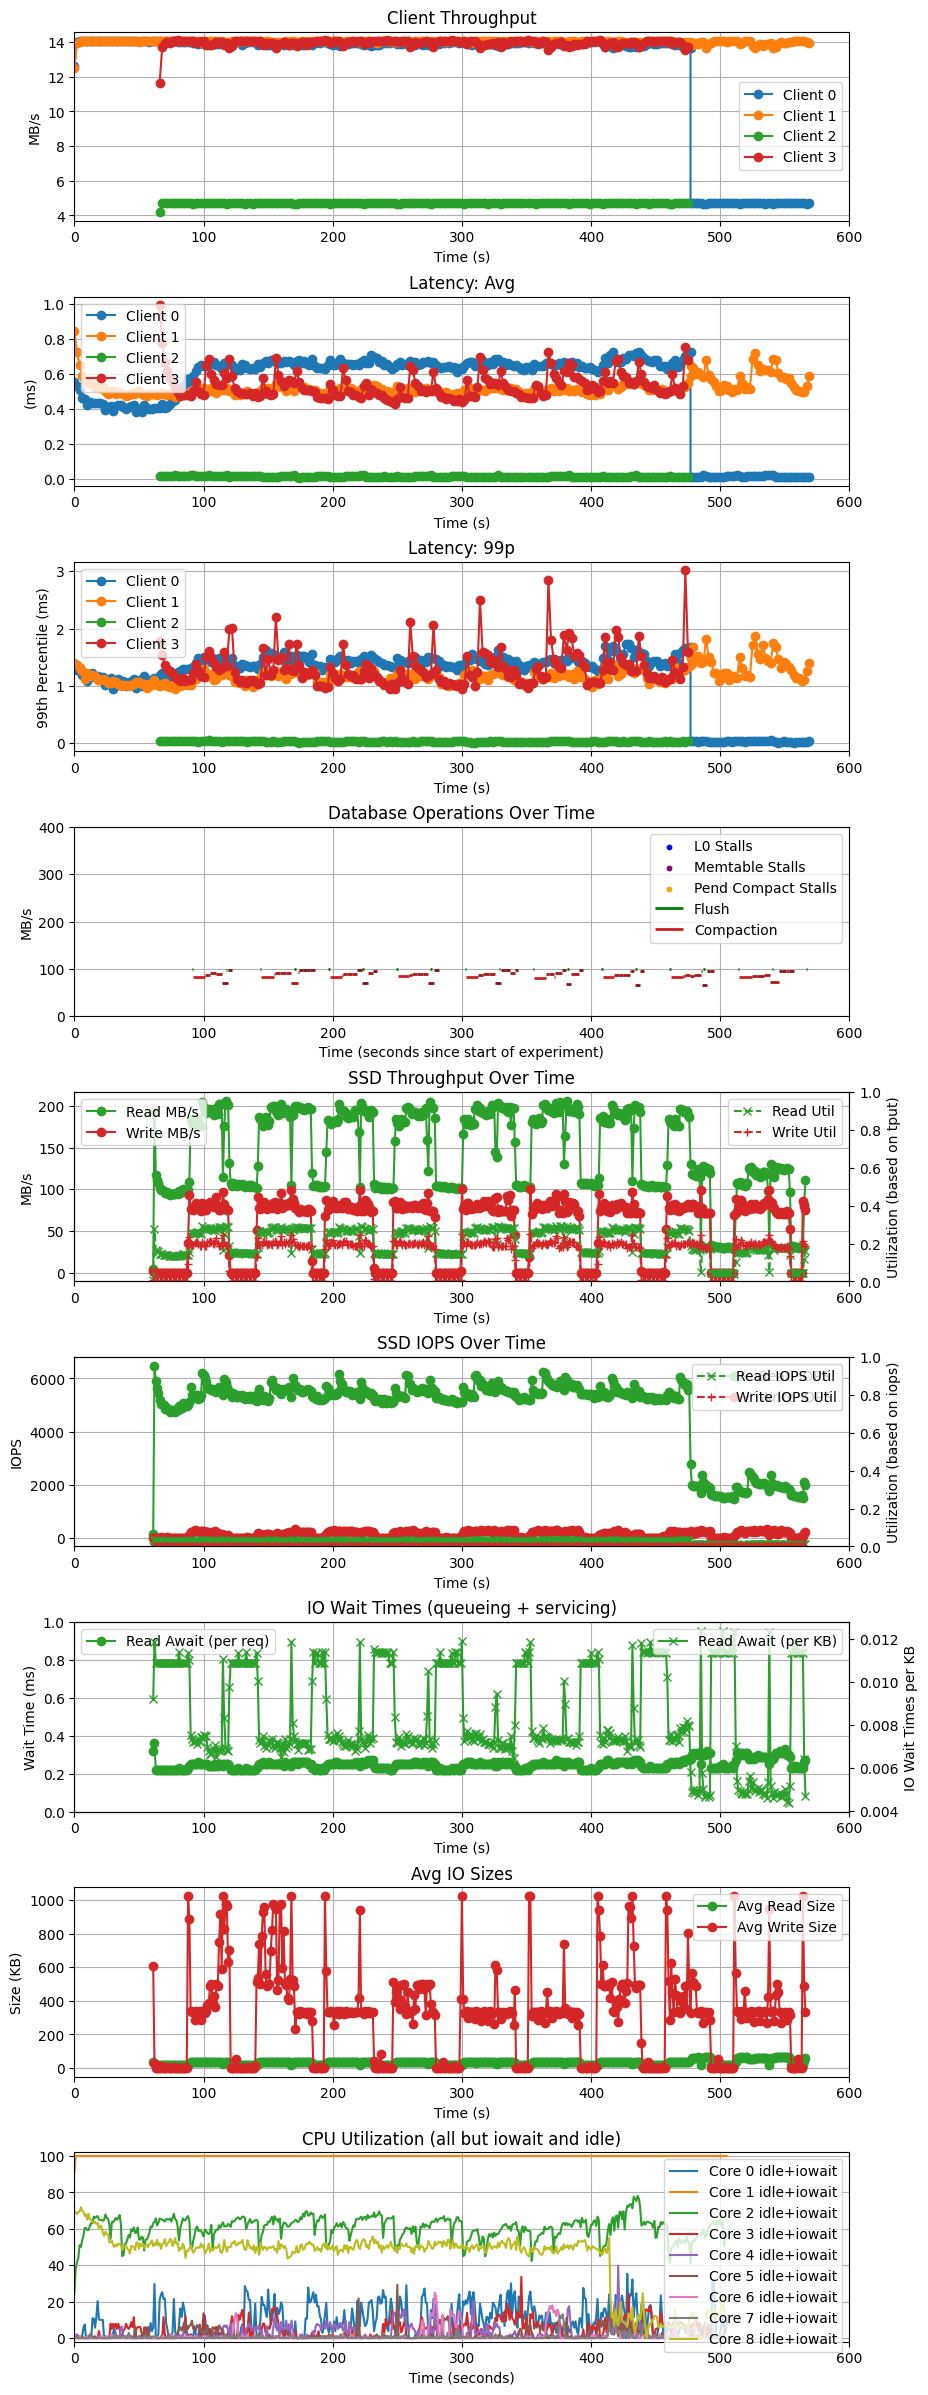

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [71]:
def generate_plots(xlim):
  fig, axs = plt.subplots(9, 1, figsize=(10, 30))
  plt.subplots_adjust(hspace=0.4)
  start_time = plot_client_results(axs, xlim)
  plot_rocksdb_events(axs, start_time, xlim, (3,0))

  start_time_shift = 61
  plot_overall_tputs(axs, start_time_shift, xlim, (4,0))
  plot_overall_iops(axs, start_time_shift, xlim, (5,0))
  plot_io_waittimes(axs, start_time_shift, xlim, (6,0))
  plot_io_reqsize(axs, start_time_shift, xlim, (7,0))
  plot_cpu_util(axs, start_time_shift, xlim, (8,0))
  plt.show()

xlim = (0, 600)
generate_plots(xlim)

In [31]:
import pandas as pd

# Define the path to your blktrace output file
file_path = 'blktrace_output.txt'
columns = ['major_minor', 'cpu', 'sequence', 'timestamp', 'pid', 'action', 'rwbs', 'sector', 'size', 'process']
data = []
temp_storage = {}

with open(file_path, 'r') as file:
  for line in file:
    # Split the line into components based on whitespace
    parts = line.split()

      # Extract the relevant parts of each line (assuming the format is consistent with your example)
    try:
      major_minor = parts[0]
      cpu = int(parts[1])
      sequence = int(parts[2])
      timestamp = float(parts[3])
      pid = int(parts[4])
      action = parts[5]
      rwbs = parts[6]
      sector = int(parts[7])
      size = int(parts[9])
      process = parts[10].strip('[]')
    except:
      continue

    # Use sector and sequence as a unique key
    # unique_key = f"{sector}_{sequence}"
    unique_key = f"{sequence}"

    # For Q action, store the information needed later to calculate duration
    if action == 'Q':
      temp_storage[unique_key] = (cpu, sequence, timestamp, pid, action, rwbs, sector, size, process)
    # For C action, calculate the duration and prepare the row for the DataFrame
    elif action == 'C' and unique_key in temp_storage:
      start_timestamp = temp_storage[unique_key][2]
      duration = timestamp - start_timestamp
      # print(unique_key, duration)
      print(temp_storage[unique_key])
      print(cpu, sequence, timestamp, pid, action, rwbs, sector, size, process)
      print()
      print()
      row = temp_storage[unique_key][:8] + (process, duration)
      data.append(row)
      del temp_storage[unique_key]

    # data.append((major_minor, cpu, sequence, timestamp, pid, action, rwbs, sector, size, process))

df = pd.DataFrame(data, columns=columns)
print(len(df))

(3, 1, 0.0, 2582781, 'Q', 'R', 34777992, 104, 'ycsb')
19 1 0.000490614 0 C R 34777992 104 0


(3, 5, 0.000135277, 2582788, 'Q', 'R', 681490904, 336, 'ycsb')
19 5 0.000721698 0 C R 689849912 408 0


(3, 9, 0.00023251, 2582789, 'Q', 'R', 681291984, 336, 'ycsb')
19 9 0.001536523 0 C R 354371080 104 0


(3, 13, 0.000323286, 2582790, 'Q', 'R', 694851736, 344, 'ycsb')
19 13 0.00247188 0 C R 606030856 368 0


(3, 17, 0.000426183, 2582791, 'Q', 'R', 689849912, 408, 'ycsb')
19 17 0.00317605 0 C R 541730256 360 0


(3, 21, 0.000544357, 2582787, 'Q', 'R', 711458992, 344, 'ycsb')
19 21 0.003885203 0 C R 536743304 352 0


(3, 25, 0.000839059, 2582781, 'Q', 'R', 78516968, 352, 'ycsb')
19 25 0.004848255 0 C R 79415928 352 0


(3, 29, 0.001062785, 2582788, 'Q', 'R', 694770800, 328, 'ycsb')
19 29 0.005485226 0 C R 78975120 448 0


(3, 33, 0.001260323, 2582789, 'Q', 'R', 354371080, 104, 'ycsb')
19 33 0.0060463 0 C R 81463608 352 0


(3, 37, 0.001453272, 2582781, 'Q', 'R', 203345088, 216, 'ycsb')
19 37 0